

### Stability Index

### Bulk Brunt–Väisälä Frequency (N²) Approximation

The code is computing the **Brunt–Väisälä frequency squared** using a finite-difference form:

$$
N^2 = \frac{g}{\bar\theta}\,\frac{d\theta}{dz}
\;\;\approx\;\;
\frac{g}{\bar\theta}\,\frac{\theta_{850}-\theta_{1000}}{\Delta z}
$$

---

#### Potential Temperature
Potential temperature at pressure $p$ is given by Poisson’s equation:

$$
\theta = T \left(\frac{p_0}{p}\right)^\kappa
$$

where  
- $T$ is temperature (K),  
- $p_0 = 1000\ \text{hPa}$ is the reference pressure,  
- $\kappa = R_d / c_p$.

---

#### Hypsometric Equation (layer thickness)
The vertical distance between pressure levels is computed using the **dry hypsometric relation** with a layer-mean temperature:

$$
\Delta z
= \frac{R_d\,\bar T}{g}\,\ln\!\left(\frac{p_{1000}}{p_{850}}\right)
$$

---

#### Final Expression
Substituting, the bulk $N^2$ between 1000 and 850 hPa is:

$$
N^2 \;\approx\;
\frac{g}{\tfrac{1}{2}(\theta_{1000}+\theta_{850})}\;
\frac{\theta_{850}-\theta_{1000}}
{\;\dfrac{R_d\,\tfrac{1}{2}(T_{1000}+T_{850})}{g}\,\ln\!\left(\tfrac{p_{1000}}{p_{850}}\right)}
\quad [\text{s}^{-2}]
$$

---

#### Assumptions
- Dry air (no virtual temperature correction).  
- Hydrostatic balance.  
- Bulk (layer-mean) approximation.  
- Positive $N^2$ ⇒ **statically stable**, negative ⇒ **unstable**.


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

In [2]:


# Resolve path given this notebook lives in intro_to_climatology_repo/data/
candidates = [Path("air.2024.nc"), Path("../data/air.2024.nc"), Path("data/air.2024.nc")]
nc_path = next((p for p in candidates if p.exists()), None)
if nc_path is None:
    raise FileNotFoundError(f"air.2024.nc not found in: {', '.join(map(str, candidates))}")
print("Using:", nc_path)

ds = xr.open_dataset(nc_path, decode_times=True)
print(ds)



Using: data/air.2024.nc
<xarray.Dataset> Size: 262MB
Dimensions:    (level: 17, lat: 73, lon: 144, time: 366, nbnds: 2)
Coordinates:
  * level      (level) float32 68B 1e+03 925.0 850.0 700.0 ... 30.0 20.0 10.0
  * lat        (lat) float32 292B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon        (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2024-12-31
Dimensions without coordinates: nbnds
Data variables:
    air        (time, level, lat, lon) float32 262MB ...
    time_bnds  (time, nbnds) float64 6kB ...
Attributes:
    Conventions:    COARDS
    title:          mean daily NMC reanalysis (2014)
    history:        created 2013/12 by Hoop (netCDF2.3)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...


Variable: air | dims: ('time', 'level', 'lat', 'lon') | units: degK
Coords -> lat: lat lon: lon lev: level


Text(0.5, 1.0, 'air at first time, 500 hPa')

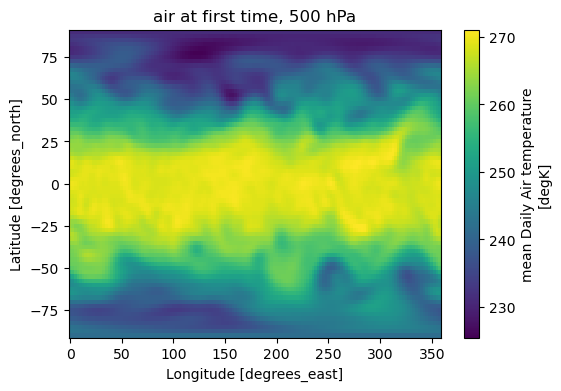

In [3]:


# Pick the air temperature variable (or first variable as fallback)
var_name = "air" if "air" in ds.data_vars else list(ds.data_vars)[0]
da = ds[var_name]
print("Variable:", var_name, "| dims:", da.dims, "| units:", da.attrs.get("units", "unknown"))

# Identify coordinate names robustly
lat_name = next((n for n in ["lat", "latitude", "y"] if n in ds.coords), None)
lon_name = next((n for n in ["lon", "longitude", "x"] if n in ds.coords), None)
lev_name = next((n for n in ["level", "lev", "plev", "isobaricInhPa"] if n in ds.coords), None)
print("Coords -> lat:", lat_name, "lon:", lon_name, "lev:", lev_name)

# Quick slice for plotting: first time, and 500 hPa if available
da2 = da.isel(time=0) if "time" in da.dims else da
if lev_name:
    try:
        # prefer exact 500, else nearest
        if 500 in np.array(da2[lev_name]):
            da2 = da2.sel({lev_name: 500})
        else:
            da2 = da2.sel({lev_name: 500}, method="nearest")
    except Exception as e:
        print("Level selection note:", e)

ax = da2.plot(figsize=(6, 4), cmap="viridis")
title = f"{var_name} at first time"
if lev_name:
    try:
        title += f", {float(da2[lev_name].values):.0f} hPa"
    except Exception:
        pass
ax.axes.set_title(title)


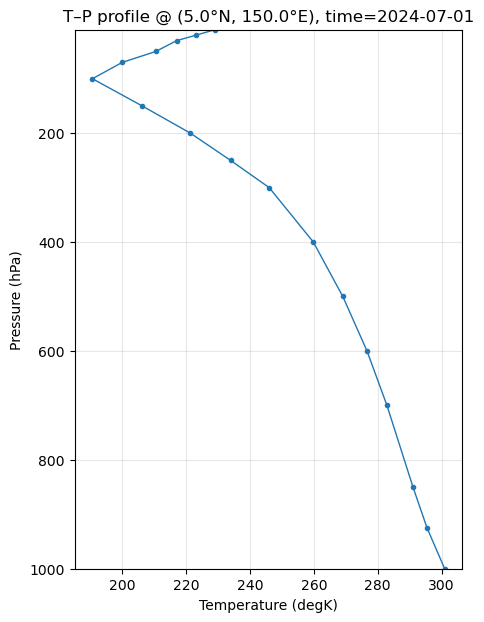

In [4]:


# 3) Select West Pacific point and time
target_lat = 5.0    # degrees North
target_lon = 150.0  # degrees East
# Normalize target lon to dataset's domain
lon_vals = np.asarray(ds[lon_name].values)
if lon_vals.min() >= 0:           # dataset uses 0..360
    target_lon_ds = target_lon % 360
else:                             # dataset uses -180..180
    target_lon_ds = target_lon if target_lon <= 180 else target_lon - 360

# Choose a time (nearest). Use first time if unsure.
time_sel = ds["time"].values[0]
# Example: pick by date nearest to '2024-07-01'
try:
    time_sel = ds["time"].sel(time="2024-07-01", method="nearest").values
except Exception:
    pass

# 4) Extract vertical profile at the selected point/time
prof = da.sel({lat_name: target_lat, lon_name: target_lon_ds}, method="nearest").sel(time=time_sel)

# 5) Prepare pressure and temperature
p = prof[lev_name].values  # expected in hPa (mb)
T = prof.values            # likely in Kelvin; convert to C for readability
units = prof.attrs.get("units", "K")
if units.lower().startswith("k"):
    Tplot = T - 273.15
    xlab = "Temperature (°C)"
else:
    Tplot = T
    xlab = f"Temperature ({units})"

# 6) Plot T vs P
plt.figure(figsize=(5,7))
plt.plot(Tplot, p, marker="o", ms=3, lw=1)
plt.gca().invert_yaxis()
# Optional: set bounds if levels are standard (e.g., 1000→100 hPa)
try:
    plt.ylim(max(p), min(p))
except Exception:
    pass
plt.xlabel(xlab)
plt.ylabel("Pressure (hPa)")
plt.title(f"T–P profile @ ({target_lat}°N, {target_lon}°E), time={np.datetime_as_string(time_sel, unit='D')}")
plt.grid(True, alpha=0.3)
plt.show()


In [5]:

# ---------------- Config ----------------
target_lat = 5.0     # degN
target_lon = 150.0   # degE
p_bottom = 1000.0    # hPa
p_top = 850.0        # hPa
# ---------------------------------------

# Physical constants
g = 9.80665         # m s^-2
Rd = 287.05         # J kg^-1 K^-1
cp = 1004.0         # J kg^-1 K^-1
kappa = Rd / cp
p0 = 1000.0         # hPa


time_name = "time" if "time" in ds.dims or "time" in ds.coords else None

if any(v is None for v in [lat_name, lon_name, lev_name, time_name]):
    raise ValueError("Could not detect lat/lon/level/time coordinate names.")

# Map longitude to dataset domain
lon_vals = np.asarray(ds[lon_name].values)
if lon_vals.min() >= 0:           # 0..360
    target_lon_ds = target_lon % 360
else:                             # -180..180
    target_lon_ds = target_lon if target_lon <= 180 else target_lon - 360

# Determine pressure unit for interpolation targets
p_coord = ds[lev_name]
p_vals = np.asarray(p_coord.values)
if np.nanmax(p_vals) > 2000:           # Pa
    p_bottom_val = p_bottom * 100.0
    p_top_val = p_top * 100.0
else:                                   # hPa
    p_bottom_val = p_bottom
    p_top_val = p_top

# Extract T(time, level) at the point
prof = da.sel({lat_name: target_lat, lon_name: target_lon_ds}, method="nearest")

# Sort by pressure (ascending) for safe interpolation
prof_sorted = prof.sortby(lev_name)

# Interpolate T at 1000 and 850 hPa for all times (vectorized)
T_bottom = prof_sorted.interp({lev_name: p_bottom_val})
T_top = prof_sorted.interp({lev_name: p_top_val})

# Robust units handling (K, degK, Kelvin, etc.)
units = str(da.attrs.get("units", "K"))
u = units.lower().replace("degrees", "").replace("degree", "").replace("deg", "").replace("°", "").strip()
if u in ("k", "kelvin") or u.endswith("k"):
    pass  # already Kelvin
elif u in ("c", "celsius"):
    T_bottom = T_bottom + 273.15
    T_top = T_top + 273.15
elif u in ("f", "fahrenheit"):
    T_bottom = (T_bottom - 32.0) * 5.0/9.0 + 273.15
    T_top = (T_top - 32.0) * 5.0/9.0 + 273.15
else:
    print(f"Warning: unrecognized temperature units='{units}', assuming Kelvin")

# Potential temperature at endpoints (Poisson eq. expects hPa ratios)
theta_bottom = T_bottom * (p0 / p_bottom) ** kappa
theta_top = T_top * (p0 / p_top) ** kappa
theta_mean = 0.5 * (theta_bottom + theta_top)

# Hypsometric thickness (dry approx; use layer-mean T)
T_mean = 0.5 * (T_bottom + T_top)
dp_ratio = (p_bottom / p_top)  # unitless ratio; same for Pa or hPa
delta_z = (Rd * T_mean / g) * np.log(dp_ratio)   # meters; vector over time

# Bulk N^2 per day over 1000–850 hPa
N2 = (g / theta_mean) * (theta_top - theta_bottom) / delta_z  # s^-2; DataArray over time


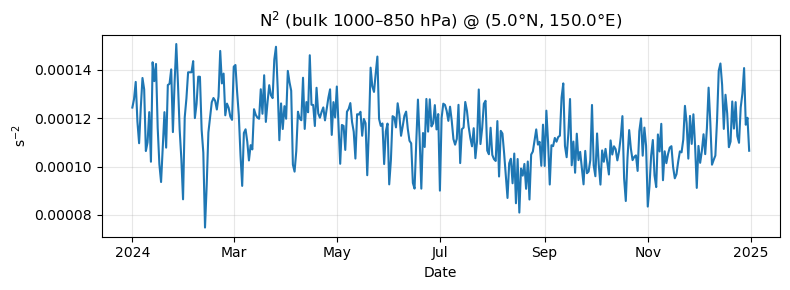

In [6]:
fig, ax = plt.subplots(figsize=(8, 3))
N2.plot(ax=ax, color="tab:blue")
ax.set_title(f"N$^2$ (bulk 1000–850 hPa) @ ({target_lat}°N, {target_lon}°E)")
ax.set_ylabel("s$^{-2}$")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.3)
plt.tight_layout()
